# Desafío - Inferencia de tópicos con EM

Luis Porras

### Descripción

* En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. Cada uno de los csv se encuentra en la carpeta `dump`.
* Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.
* En base a esta información, el objetivo del ejercicio es generar un modelo probabilístico que pueda identificar el género musical más probable dado la letra de una canción. Para ello implementaremos un modelo conocido como Latent Dirichlet Allocation que hace uso de una variante del algoritmo EM para inferir clases latentes a partir de una matriz de documentos.

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import glob
import os

warnings.filterwarnings(action='ignore')

# Configuración de gráficas
plt.rcParams["figure.figsize"] = (20, 15)
plt.rcParams["figure.dpi"] = 80
sns.set_style('darkgrid')

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import LatentDirichletAllocation # Variación del algoritmo EM para extracción de tópicos

In [2]:
pd.read_csv(os.getcwd() +  '/' + glob.glob('dump/*.csv')[0]).head()

,Unnamed: 0,0,1,2,3
0,0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee..."
1,1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...
2,2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...
3,3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...
4,4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...


In [3]:
# Recuperar la Lista con todos los .csv en la carpeta dump
current_path = os.getcwd()
dump_dfs = list(map(lambda path: pd.read_csv(current_path + '/' + path), glob.glob('dump/*.csv')))
df = pd.concat(dump_dfs).drop(columns=['Unnamed: 0'])
df.columns = ['Artist', 'Genre', 'Song', 'Lyrics']
df.sample(5)

,Artist,Genre,Song,Lyrics
62,Deicide,metal,From Darkness Come,I take his name in vain and devastate; disgrac...
9,Mos Def,hiphop,Rock N Roll,"Make me want to holla, ow (Ah, ah ah ah ah, ah..."
76,Faith No More,rock,The World Is Yours,Keep your distance \n You're in the race (?) \...
184,Queen,rock,Jailhouse Rock,The prison band was there and they began to wa...
152,Modest Mouse,rock,Too Many Fiestas For Rueben,"He's 25, hanging out at the high school \n Eve..."


In [4]:
df.shape

(9489, 4)

In [5]:
df['Genre'].value_counts()

rock      4140
hiphop    2535
metal     1582
pop       1232
Name: Genre, dtype: int64

In [9]:
counter = CountVectorizer(stop_words='english', max_features=5000, max_df=.1)

transformed_feats = counter.fit_transform(df['Lyrics'])

transformed_feats.toarray().shape

(9489, 5000)

In [10]:
search_params = {'n_components': [5, 10, 15], 'learning_decay': [0.7, 0.5]}

In [11]:
%%time
cv_lda_model = GridSearchCV(LatentDirichletAllocation(learning_method='online'),
                            param_grid=search_params, n_jobs=-1,
                           cv=5).fit(transformed_feats)

Wall time: 2min 17s


In [12]:
best_lda = cv_lda_model.best_estimator_

In [15]:
print("Best hyperparams: {}".format(cv_lda_model.best_params_))
print("Best Loglikelihood: {}".format(cv_lda_model.best_score_))
print("Best Preplexity: {}".format(best_lda.perplexity(transformed_feats)))

Best hyperparams: {'learning_decay': 0.7, 'n_components': 5}
Best Loglikelihood: -1323792.6673532487
Best Preplexity: 2263.107095751633


In [16]:
from joblib import dump, load

In [18]:
dump(cv_lda_model.best_estimator_, 'Latent_dirichlet_alloc.joblib')
best_lda = load('Latent_dirichlet_alloc.joblib')

## Ejercicio 4: Identificacion de Topicos

In [19]:
for topic_id, topic_name in enumerate(best_lda.components_):
    print("tópico: {}".format(topic_id + 1))
    print(" ".join([counter.get_feature_names()[i] for 
                    i in topic_name.argsort()[:-15 - 1: -1]]))

tópico: 1
tonight ooh everybody yes dance sun rain believe walk stand sing wish waiting dream true
tópico: 2
na body days forever burn young change hope wrong game took jesus caught pay tired
tópico: 3
la war hell pain earth fear power fight lord free lost lies born land kill
tópico: 4
niggas uh niggaz rock ma rap wit bitches gon bout fuckin da beat son check
tópico: 5
ah ha ooh whoa crazy work talk going hate getting mean best damn future moment


## Ejercicio 5: Identificacion de probabilidaes

In [22]:
fit_best_lda = best_lda.transform(transformed_feats)

topics_for_each_doc = pd.DataFrame(
    np.round(fit_best_lda, 3),
    index=df.index
)

topics_for_each_doc.columns = list(
    map(lambda x: "T: {}".format(x),
    range(1, best_lda.n_components + 1)))

topics_for_each_doc.head()

,T: 1,T: 2,T: 3,T: 4,T: 5
0,0.062,0.104,0.745,0.082,0.008
1,0.279,0.113,0.232,0.369,0.006
2,0.004,0.004,0.985,0.004,0.004
3,0.066,0.409,0.270,0.251,0.004
4,0.047,0.004,0.892,0.052,0.004


In [23]:
concatenated_df = pd.concat([df, topics_for_each_doc], axis=1)

concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis=1) + 1

In [24]:
concatenated_df.sample(10)

,Artist,Genre,Song,Lyrics,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
20,Rush,rock,The Fountain Of Lamneth,I. In the Valley \n I am born \n I am me \n I ...,0.257,0.137,0.597,0.008,0.001,3
130,Bruce Springsteen,rock,Straight Time,Got out of prison back in '86 and I found a wi...,0.297,0.255,0.148,0.298,0.002,4
96,SIA,pop,The Greatest,"Uh-oh, running out of breath \n But I, oh, I, ...",0.083,0.103,0.368,0.432,0.013,4
143,Megadeth,metal,The Right To Go Insane,I barely get to the graveyard shift on time \n...,0.005,0.300,0.348,0.071,0.276,3
51,Method Man,hiphop,Ridin' For Outro,(Black Ice) \n Three young cats strapped with ...,0.107,0.215,0.269,0.406,0.003,4
38,Bruce Springsteen,rock,Independence Day,"Well Papa, go to bed now, it's getting late \n...",0.595,0.173,0.111,0.003,0.119,1
172,Britney Spears,pop,Kiss You All Over,I wanna kisssssssss you all over \n Gimme that...,0.370,0.097,0.002,0.002,0.528,5
41,Kanye West,hiphop,We Can Make It Better,"(Kanye West) \n (""Make It Up"") We can make it ...",0.002,0.081,0.179,0.580,0.158,4
92,Method Man,hiphop,Mef Vs Chef 2,"Yo, blow my nose for me, man \n Word up, man (...",0.075,0.105,0.001,0.775,0.043,4
72,Meshuggah,metal,Born In Dissonance,"We are origin, we are increate \n You will see...",0.128,0.006,0.853,0.006,0.006,3


Matriz de correlacion entre topicos

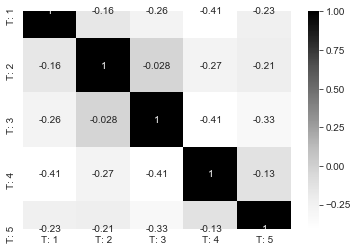

In [26]:
import seaborn as sn
sn.heatmap(concatenated_df.loc[:, 'T: 1': 'T: 5'].corr(), annot=True, cmap='Greys')

In [27]:
def fetch_mixture(df, artist):
    return df[df['Artist'] == artist].loc[:, 'T: 1':'T: 5']
mos_def = fetch_mixture(concatenated_df, 'Lorde')
mos_def.columns = ['hardcore-rap', 'rock', 'pop', 'metal', 'bling-era']
mos_def.apply(np.mean, axis=0).sort_values()

pop             0.095444
metal           0.100630
rock            0.165333
bling-era       0.224259
hardcore-rap    0.414185
dtype: float64

(-0.5, 1599.5, 1199.5, -0.5)

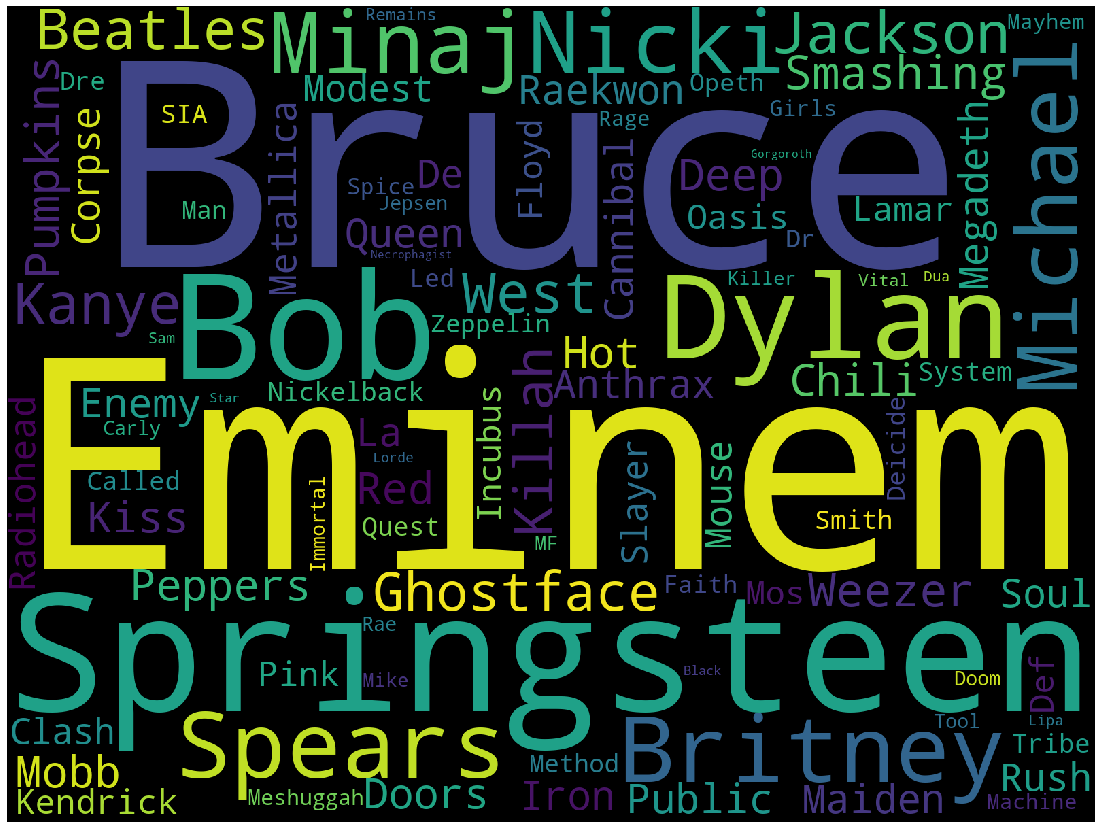

In [30]:
from wordcloud import WordCloud

#wordcloud de artistas
cloud = WordCloud(width=1600, height=1200, collocations=False).generate(" ".join(df['Artist'].astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

Distribucion de probabilidades para un artista:

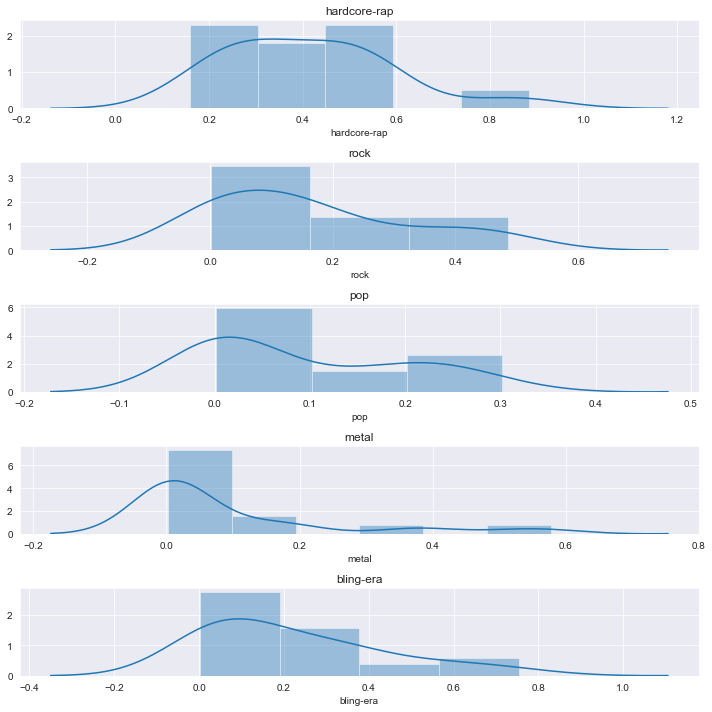

In [31]:
plt.figure(figsize=(10, 10))
for index, (colname, serie) in enumerate(mos_def.iteritems()):
    plt.subplot(5, 1, index + 1)
    sn.distplot(serie)
    plt.title(colname)
    plt.tight_layout()